In [9]:
!pip install ydf


   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   - -------------------------------------- 0.3/5.3 MB ? eta -:--:--
   --- ------------------------------------ 0.5/5.3 MB 985.5 kB/s eta 0:00:05
   --- ------------------------------------ 0.5/5.3 MB 985.5 kB/s eta 0:00:05
   ----- ---------------------------------- 0.8/5.3 MB 987.4 kB/s eta 0:00:05
   ------- -------------------------------- 1.0/5.3 MB 1.1 MB/s eta 0:00:04
   ------- -------------------------------- 1.0/5.3 MB 1.1 MB/s eta 0:00:04
   ------- -------------------------------- 1.0/5.3 MB 1.1 MB/s eta 0:00:04
   ------- -------------------------------- 1.0/5.3 MB 1.1 MB/s eta 0:00:04
   ------- -------------------------------- 1.0/5.3 MB 1.1 MB/s eta 0:00:04
   --------- ------------------------------ 1.3/5.3 MB 532.5 kB/s eta 0:00:08
   ----------- ---------------------------- 1.6/5.3 MB 599.0 kB/s eta 0:00:07
   ------------- ------

In [1]:
import ydf
import pandas as pd
import numpy as np
from scipy.stats import skew


## Load + Combine Datasets

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test['SalePrice'] = np.nan
train['TrainFlag'] = 1
test['TrainFlag'] = 0

full = pd.concat([train, test], axis=0)


## Preprocessing

In [8]:
num_cols = full.select_dtypes(include=['int64', 'float64']).columns
cat_cols = full.select_dtypes(include=['object']).columns

# Fill missing values
full[num_cols] = full[num_cols].fillna(full[num_cols].median())
full[cat_cols] = full[cat_cols].fillna('Missing')

## Feature Engineering

In [11]:
full['TotalBathrooms'] = (
    full['FullBath'] + 0.5 * full['HalfBath'] +
    full['BsmtFullBath'] + 0.5 * full['BsmtHalfBath']
)

full['TotalSF'] = full['TotalBsmtSF'] + full['1stFlrSF'] + full['2ndFlrSF']
full['IsRemodeled'] = (full['YearBuilt'] != full['YearRemodAdd']).astype(int)
full['AgeOfHouse'] = full['YrSold'] - full['YearBuilt']


## Handle Skewed Numerical Features

In [14]:
skewed_feats = full[num_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_cols = skewed_feats[skewed_feats > 0.75].index
full[skewed_cols] = np.log1p(full[skewed_cols])


## One-Hot Encode Categoricals

In [17]:
full = pd.get_dummies(full, columns=cat_cols)


## Train/Test Split for YDF

In [19]:
train_df = full[full['TrainFlag'] == 1].drop(columns=['TrainFlag'])
test_df = full[full['TrainFlag'] == 0].drop(columns=['TrainFlag', 'SalePrice'])

X_train = train_df.drop(columns='SalePrice')
y_train = train_df['SalePrice']

In [20]:
train_for_ydf = X_train.copy()
train_for_ydf['SalePrice'] = y_train


## Training YDF Model

In [22]:
print(dir(ydf)) 

['Activation', 'BinaryClassificationLoss', 'CARTModel', 'CartLearner', 'Column', 'DecisionTreeLearner', 'DistributedGradientBoostedTreesLearner', 'Feature', 'GenericLearner', 'GenericModel', 'GradientBoostedTreesLearner', 'GradientBoostedTreesModel', 'IsolationForestLearner', 'IsolationForestModel', 'ModelIOOptions', 'ModelMetadata', 'MultiClassificationLoss', 'NodeFormat', 'RandomForestLearner', 'RandomForestModel', 'RandomSearchTuner', 'RegressionLoss', 'Semantic', 'Task', 'VizierTuner', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_check_install', 'api', 'cc', 'create_vertical_dataset', 'dataset', 'deserialize_model', 'from_sklearn', 'from_tensorflow_decision_forests', 'internal', 'learner', 'load_model', 'metric', 'model', 'monitoring', 'start_worker', 'strict', 'tree', 'util', 'utils', 'verbose', 'version']


In [23]:
learner = ydf.GradientBoostedTreesLearner(label="SalePrice", task=ydf.Task.REGRESSION)
model = learner.train(train_for_ydf)

Train model on 1460 examples
Model trained in 0:00:06.316874


## Predict

In [25]:
preds = model.predict(test_df)
test_preds = preds

## Submission file

In [27]:
submission = pd.read_csv('sample_submission.csv')
submission['SalePrice'] = np.expm1(test_preds.squeeze())
submission['SalePrice'] = submission['SalePrice'].clip(lower=0)

submission.to_csv('submission.csv', index=False)


In [28]:
print(submission.head())


     Id      SalePrice
0  1461  127430.945312
1  1462  164512.500000
2  1463  187584.625000
3  1464  187350.406250
4  1465  182519.421875


## SalePrice Distribution
to understand skewness or outliers.

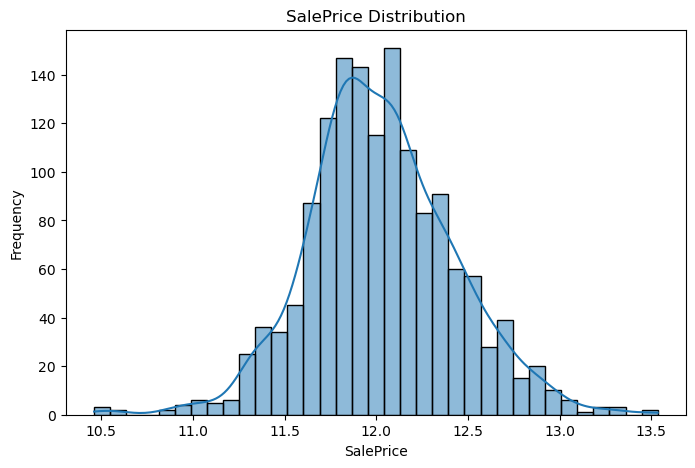

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(train_df["SalePrice"], kde=True)
plt.title("SalePrice Distribution")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()


## Correlation Heatmap
top correlated features with SalePrice.

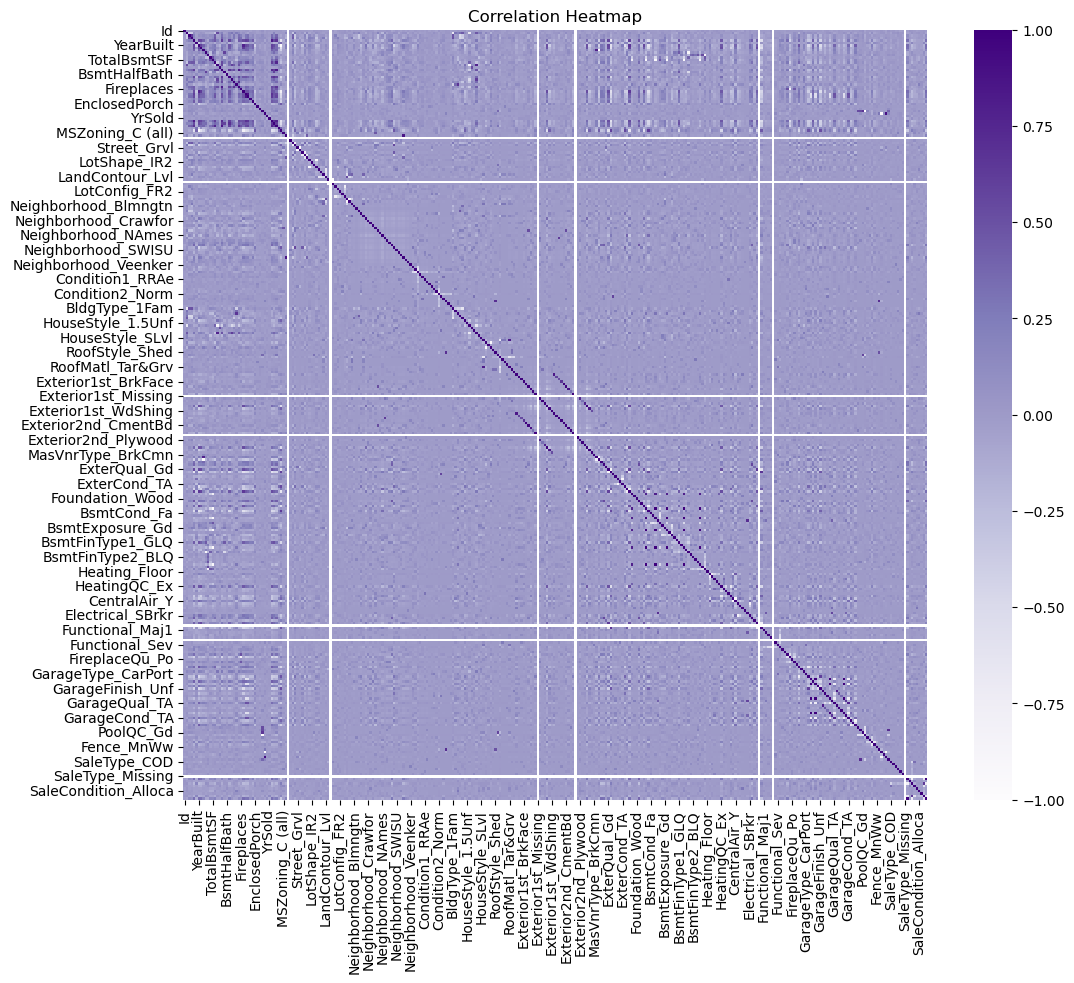

In [70]:
plt.figure(figsize=(12, 10))
corr = train_df.corr(numeric_only=True)
sns.heatmap(corr, cmap='Purples', annot=False)
plt.title("Correlation Heatmap")
plt.show()


In [72]:
corr_target = corr["SalePrice"].sort_values(ascending=False)
print(corr_target.head(10))

SalePrice         1.000000
OverallQual       0.817185
TotalSF           0.777297
GrLivArea         0.730254
GarageCars        0.680625
TotalBathrooms    0.673011
GarageArea        0.650888
1stFlrSF          0.608955
FullBath          0.594771
YearBuilt         0.586570
Name: SalePrice, dtype: float64


##  Scatter Plots for Top Features
For top correlated features like GrLivArea, OverallQual:

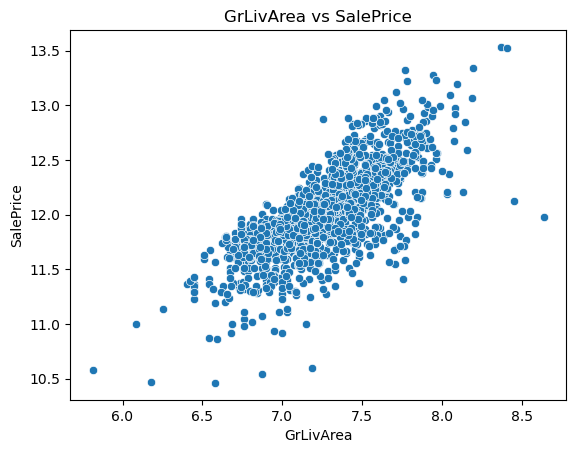

In [77]:
sns.scatterplot(data=train_df, x="GrLivArea", y="SalePrice")
plt.title("GrLivArea vs SalePrice")
plt.show()


## Boxplot for Categorical Variables
See price trends by category 

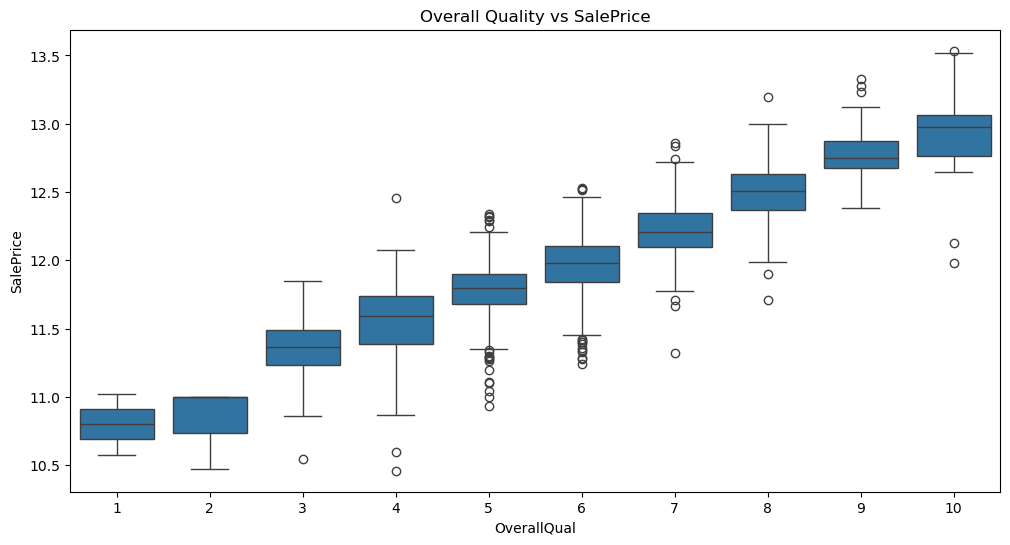

In [82]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='OverallQual', y='SalePrice', data=train_df)
plt.title("Overall Quality vs SalePrice")
plt.show()


### Observations from "OverallQual vs SalePrice" Boxplot

- Strong Positive Relationship
    - As OverallQual (Overall Material and Finish Quality) increases, the median of SalePrice (log-transformed) consistently rises.
    - This shows a clear upward trend, indicating that houses with better build quality tend to fetch higher prices.

- Wider Spread at Higher Qualities
    - For OverallQual values from 7 to 10, the boxplots show wider interquartile ranges and more outliers.
    - This suggests that high-quality homes vary more in price, possibly due to other factors like location, size, amenities, etc.

- Lower Quality Homes are Tightly Clustered
    - For OverallQual between 1 and 4, prices are lower and distributions are tighter — less variability in price.
    - Buyers generally expect lower variation among low-quality homes.
      
- Outliers
    - Across all quality levels, especially in the mid-range (5-7), there are many outliers.
    - These might be homes with unusual combinations (e.g., decent quality but bad location, or vice versa), and could be worth deeper inspection during outlier handling.